In [93]:
# 调包
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat

from scipy.signal import welch, firwin2, fftconvolve


In [94]:
# 定义LISA噪音功率谱公式（其实在LISA的文章中已经给出了python包）
def lisa_noise_psd(A,f,coefs):
    sc = A * f ** (-7 /3) * np.exp(-f ** coefs[0] + coefs[1]* f *np.sin(coefs[2])) * (1 + np.tanh(coefs[3] *(coefs[4] - f)))
    poms = 1.5e-11 ** 2 * (1 + (2e-3 / f) ** 4)
    pacc = 3e-15 * (1 + (0.4e-3/ f) ** 2) * (1 + (f / 8e-3) ** 4)
    
    sn = 10 / (3 * (2.5e9 ** 2)) * (poms + (4 * pacc) / (2 * np.pi * f) ** 4) * (1 + (6 / 10) * (f / 19.09e-3) ** 2) + sc
    
    return sn

def generate_noise(filter_order,samples,noise,psd,freq_vec):
    freq_vec[0] = 0
    freq_vec[-1] = samples / 2
    b = firwin2(filter_order + 1,freq_vec/ (samples/2),np.sqrt(psd))
    out_noise = fftconvolve(noise,b) #* np.sqrt(samples) 
    return out_noise

# def generate_noise_test(noise,psd):
#     noise_fft = np.fft.fft(noise)
#     out_noise_fft = noise_fft * np.sqrt(psd)
#     out_noise  = np.fft.ifft(out_noise_fft).real
#     return out_noise


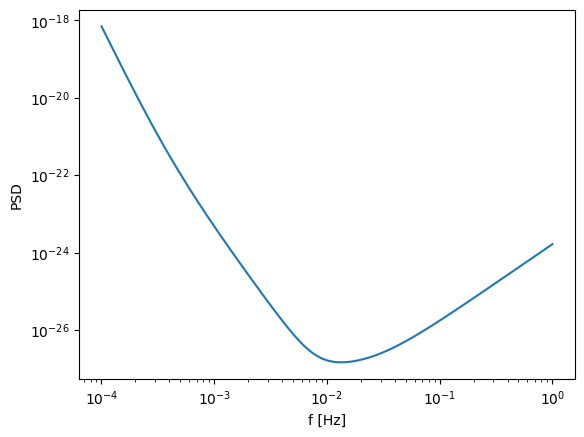

In [95]:
# 计算LISA的PSD
nsamples = 2 ** 14

timeVec = np.linspace(0, 2000, nsamples)

data_len = timeVec[-1] - timeVec[0]

samples = nsamples / data_len

kNyq = samples

posfreqs = np.linspace(1e-4,1e0,nsamples)

A = 9e-45

coefs = np.array([0.133,243,482,917,0.00258])
psd = lisa_noise_psd(A,posfreqs,coefs)
# psd = psd * 1e2

fig, ax = plt.subplots()

# 对数刻度
ax.set_xscale('log')
ax.set_yscale('log')

# 设置标签
ax.set_xlabel('f [Hz]')
ax.set_ylabel('PSD')

# 绘图
ax.plot(posfreqs, psd)
plt.show()

In [96]:
# 生成噪声
np.random.seed(kNyq.astype(int))
initial_noise = np.random.normal(0,1,nsamples)
# 设置滤波器阶数
filter_ordr = 2 ** 10

# 由于前面的频率太低不能用，所以使用一个临时噪声
# lin_freq = np.linspace(0,samples/2,nsamples)
# 使用滤波器来生成有色噪声
output_noise = generate_noise(filter_ordr,samples,initial_noise,psd,posfreqs)



# 实验 （得到的结果最终是个平谱。psd线可直）
# output_noise = generate_noise_test(initial_noise,psd)



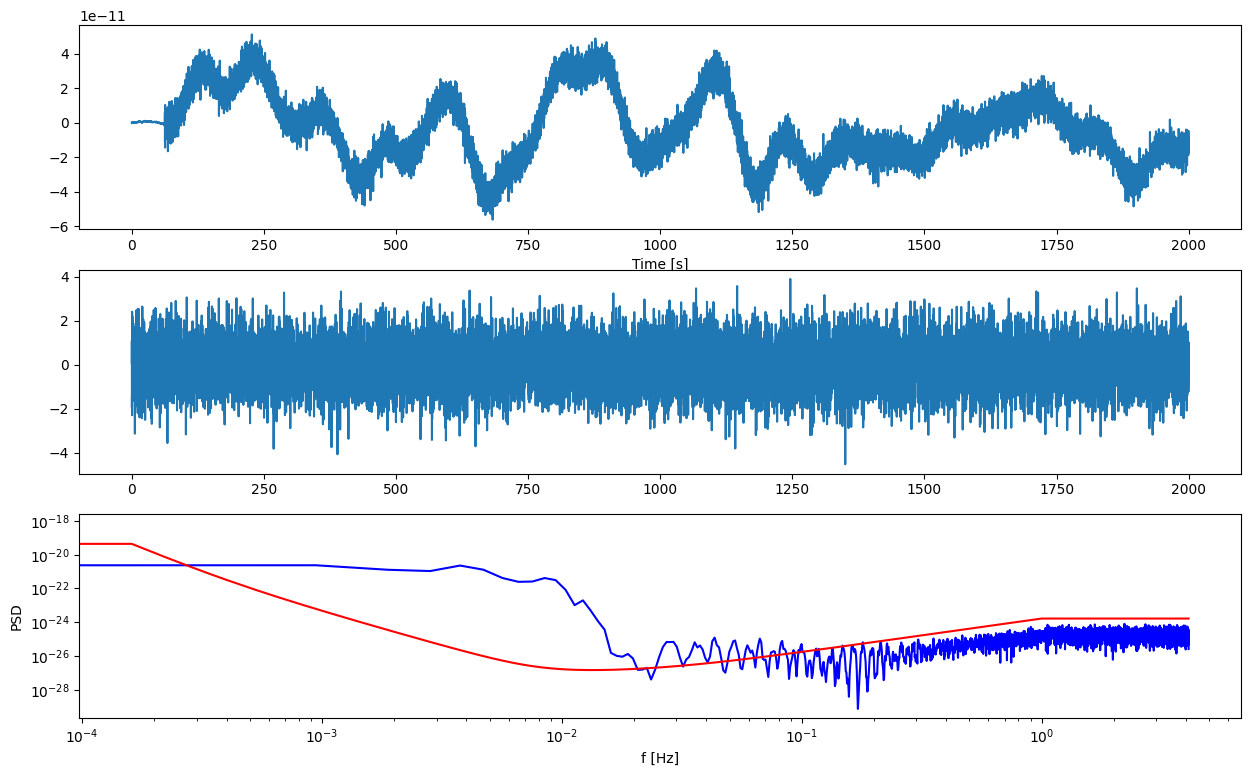

In [97]:

f1, pxx1 = welch(output_noise, fs=samples, nperseg=len(output_noise)//2, noverlap=len(output_noise)//4)
pxx1 = pxx1 / 2
output_noise = output_noise * np.sqrt(np.mean(psd) / np.mean(pxx1))
# len_min = min(len(timeVec),len(output_noise),len(initial_noise))
# 
# timeVec = timeVec[:len_min]
# output_noise = output_noise[:len_min]
# initial_noise = initial_noise[:len_min]

fig1 = plt.figure(figsize=(15,9))
ax = plt.subplot(311)
ax.plot(timeVec, output_noise[:len(timeVec)])
ax.set_xlabel('Time [s]')

ax = plt.subplot(312)
ax.plot(timeVec, initial_noise)

savemat('noise.mat',{'noise':output_noise})

# fig2 = plt.figure(figsize=(15,9))
ax = plt.subplot(313)
ax.plot(f1,pxx1,label='generate noise',color='blue')
ax.plot(posfreqs,psd,color='red',label='target psd')
# ax.set_xlim(1e-4,1e0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('f [Hz]')
ax.set_ylabel('PSD')
plt.show()




In [98]:
# 获取总数据
data_sigal = loadmat('signal.mat')
data_noise = loadmat('noise.mat')

signal = data_sigal['signal'][0]
noise = data_noise['noise'][0]
# 噪声的强度乘以放大因子影响了psd
# noise = noise 


len_min = min(signal.shape, noise.shape)


signal = signal[:len_min[0]]
noise = noise[:len_min[0]]

data = signal + noise

# print(data)
savemat('data.mat',{'data':data,'samples':samples.astype(int)})



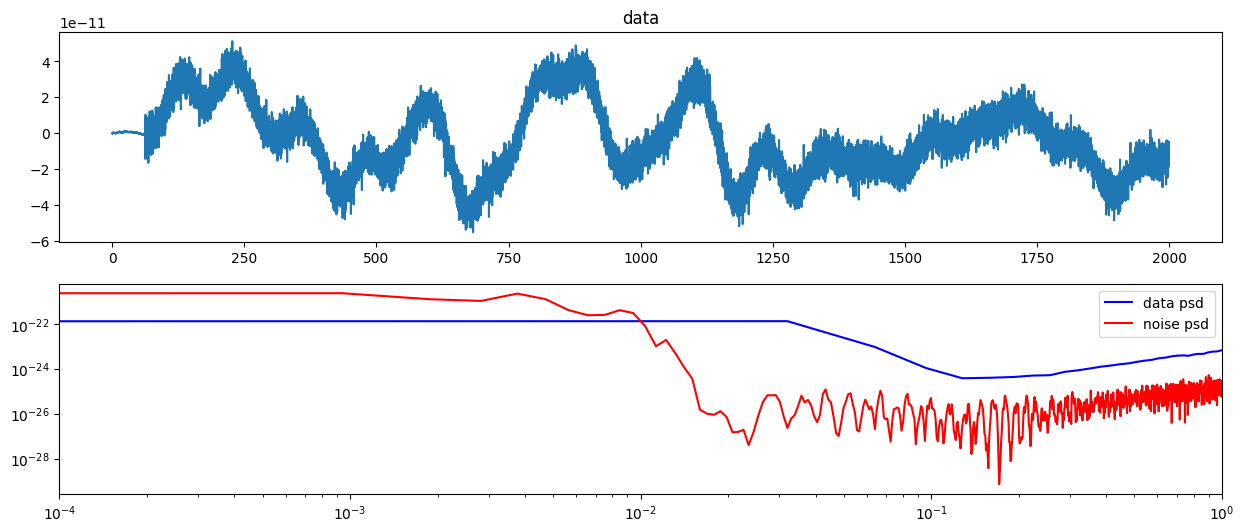

In [99]:
fig = plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(timeVec, data)
plt.title('data')

plt.subplot(2,1,2)
f,pxx = welch(data,fs=samples)
plt.plot(f,np.abs(pxx),'b',label='data psd')
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4,1e0)


plt.plot(f1,pxx1,'red',label = 'noise psd')
plt.legend()
plt.show()

In [100]:
# data_analyze = loadmat('data.mat')
# 
# samples = data_analyze['samples']
# data = data_analyze['data'][0]


In [101]:
# fig2 = plt.figure(figsize=(10,4))
# ax = plt.subplot(211)
# ax.plot(timeVec, output_noise[:len(timeVec)] * 1e-10)
# ax.set_xlabel('Time [s]')
# ax.set_title(f'f =  {filter_ordr}')
# 
# # fig2 = plt.figure(figsize=(15,9))
# ax = plt.subplot(212)
# ax.plot(f1,pxx1,label='generate noise',color='blue')
# ax.plot(posfreqs,psd,color='red',label='target psd')
# # ax.set_xlim(1e-4,1e0)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('f [Hz]')
# ax.set_ylabel('PSD')
# ax.legend()
# plt.show()